In [10]:
# setup the library
from pathlib import Path
import requests
import pickle
import gzip
import numpy as np
from matplotlib import pyplot
import cv2 as cv

# load pytorch lib
import torch
from torch import optim
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

In [11]:
# get the minst data

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)
        
# get the training data
with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

# convert data to tensor format
x_train, y_train, x_valid, y_valid = map(torch.tensor, (x_train, y_train, x_valid, y_valid))

# batch size
bs = 50

# pytorch DataLoader implementation 
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

In [32]:
# define model
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=1, padding=1)

    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        return xb

lr = 0.02

# utitiy functions

# loss function
loss_func = F.cross_entropy

# loss batches function for fitting function
def loss_batch(model, loss_func, xb, yb, opt=None):
    pre = model(xb)
    pre = F.avg_pool2d(pre, 14)
    pre = pre.view(-1, pre.size(1))
    loss = loss_func(pre, yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

# define fit function
def fit(epochs, model, loss_func, opt, train_dl, valid_dl, best_model_path):
    val_loss = 10000
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss_tmp = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        if val_loss_tmp < val_loss:
            val_loss = val_loss_tmp
            torch.save(model.state_dict(), best_model_path)
        print(epoch, val_loss)

In [33]:
model = Mnist_CNN()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

epochs = 20
best_model_path = "model/bestmodel.pth"
fit(epochs, model, loss_func, opt, train_dl, valid_dl, best_model_path)

#model.load_state_dict(torch.load(best_model_path))

0 1.569545785188675
1 0.504532874673605
2 0.4489577078819275
3 0.3246812868863344
4 0.27792303256690504
5 0.19657398283481597
6 0.18692216388881205
7 0.18692216388881205
8 0.16457076270133256
9 0.16457076270133256
10 0.16457076270133256
11 0.15454575167037546
12 0.14215258645825088
13 0.13260146336629985
14 0.12046538476832211
15 0.12046538476832211
16 0.10463190460577607
17 0.10463190460577607
18 0.10463190460577607
19 0.10463190460577607


In [56]:
# help function for ploting multiple pictures 

def plot_multiple(images, titles, colormap='gray', max_columns=np.inf, share_axes=True):
    """Plot multiple images as subplots on a grid."""
    assert len(images) == len(titles)
    n_images = len(images)
    n_cols = min(max_columns, n_images)
    n_rows = int(np.ceil(n_images / n_cols))
    fig, axes = pyplot.subplots(
        n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2),
        squeeze=False, sharex=share_axes, sharey=share_axes)

    axes = axes.flat
    # Hide subplots without content
    for ax in axes[n_images:]:
        ax.axis('off')
        
    if not isinstance(colormap, (list,tuple)):
        colormaps = [colormap]*n_images
    else:
        colormaps = colormap

    for ax, image, title, cmap in zip(axes, images, titles, colormaps):
        ax.imshow(image, cmap=cmap)
        ax.set_title(title)
        
    fig.tight_layout()

def heapmap(model, image):
    # get the output as feature map 
    output = model(image)
    
    # coefficient for each feature map
    coeffi = F.avg_pool2d(output, 7)
    coeffi = coeffi.view(-1, coeffi.size(1))
    coe_sum = coeffi.sum()
    coeffi_normalize = coeffi / coe_sum # normalize coefficient for each class
    coeffi_normalize = coeffi_normalize.detach().numpy()
    
    output = output.squeeze(0).detach().numpy()
    
    # generate the heapmap
    heatmap = np.zeros((28, 28))
    for idx in range(10):
        tmp = output[idx, :, :]
        resized = cv.resize(tmp, (21, 21), interpolation=cv.INTER_CUBIC)
        #heatmap += resized*coeffi_normalize[0][idx]
        
        ''' crop the position '''
        empty = np.zeros((28, 28))
        halfedge = resized.shape[0]//2
        edge = resized.shape[0]
        empty[14-halfedge:14-halfedge+edge, 14-halfedge:14-halfedge+edge] = resized
        heatmap += empty*coeffi_normalize[0][idx]

    return heatmap

In [57]:
# generate heapmap pic from the training set
def generate_plot_pic(start, end):
    heatmaplist = [heapmap(model, tmp) for tmp in x_train[start:end]]
    origiallist = x_train[start:end]
    image = []
    for tmp1, tmp2 in zip(heatmaplist, origiallist):
        image.append(tmp2.reshape((28, 28)))
        image.append(tmp1)
    
    title = y_train[start: end].detach().numpy()
    
    titlelist = []
    for tmp in title:
        tmp = str(tmp)
        titlelist.append(tmp + ' origin')
        titlelist.append(tmp + ' heatmap')
        
    cmaplist = ['gray', 'magma'] * (end - start)
    return image, titlelist, cmaplist
    

<IPython.core.display.Javascript object>


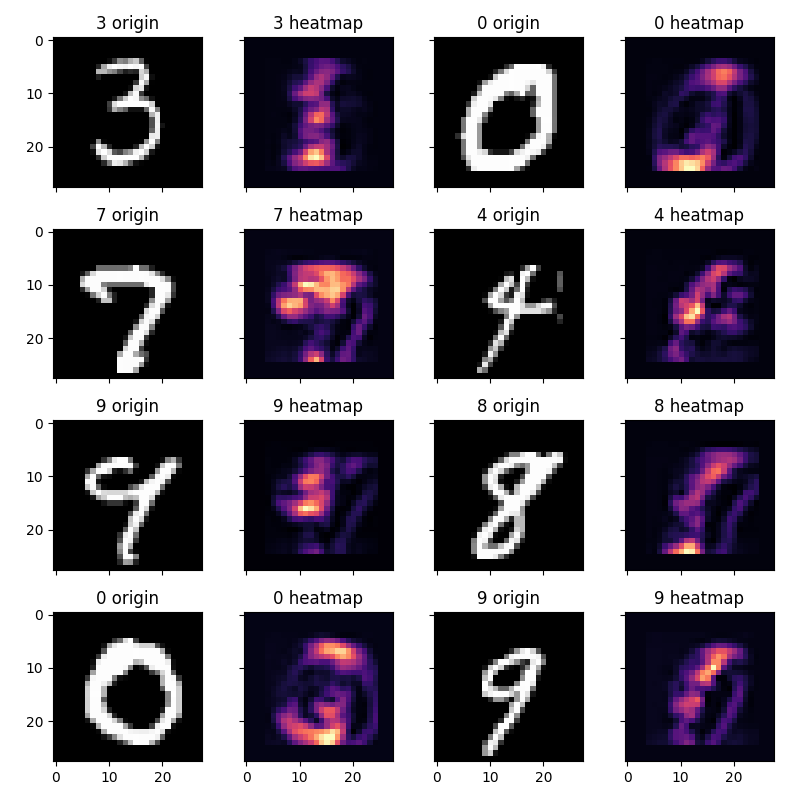

In [58]:
%matplotlib notebook
image, title, cmaplist = generate_plot_pic(50, 58)
plot_multiple(image, title, cmaplist, 4)